# Plotting sea ice in the Southern Ocean
This script produces plots of sea ice area around the Southern Ocean using outputs from ACCESS-OM2-01.  
**Requirements:** It is suggested you use the `conda/analysis3-20.01` (or later) kernel. This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a Python cell.

## Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import os
import calendar
from dask.distributed import Client
from tqdm import tqdm_notebook #to access observations
import gc #to free up memory
#Activate if needed
# import copy

The following modules are used in map creation.

In [2]:
import cmocean as cm                              # Nice colormaps
from collections import OrderedDict               # We often use this to organise our experiments
import cftime                                     # In case you need to work with time axes
from glob import glob                             # If you need to search file systems
import cartopy.crs as ccrs                        # For making maps with different projections
import cartopy.feature as cft                     # For adding features to maps

## Accessing model outputs
Start a cluster that has multiple cores to work with. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [3]:
client = Client(n_workers = 12)

Access the default database of experiments from where data will be loaded.

In [4]:
session = cc.database.create_session()

This notebook uses the outputs for the v140 run of ACCESS-OM2-01 which includes wind forcing. Includes experiments `01deg_jra55v140_iaf` and `01deg_jra55v140_iaf`. A list of experiments can be accessed using `cc.querying.get_experiments(session)`, you can get a detailed list of experiments by adding `all = True` argument.

In [5]:
#Saving name of experiments of interest in variables that can be easily referred to
#expv140 = "01deg_jra55v140_iaf"
exp = "01deg_jra55v140_iaf_cycle2"

### Experiment variables
You can query the temporal frequency of all variables available in the experiment using `cc.querying.get_frequencies(session, experiment)`. A list of experiment variables can be obtained using `cc.querying.get_variables(session, experiment, frequency)`.

In [32]:
#Activate the lines below to query temporal frequency
cc.querying.get_frequencies(session, exp)

,frequency
0,None
1,1 daily
2,1 monthly
3,static


Asking for user input to query experiment variable list

In [34]:
#Querying experiment variables
expvar = cc.querying.get_variables(session, exp, frequency = "1 daily")

#Extract variables with keywords included in its long_name column
expvar[expvar["long_name"].str.lower().str.match(".*ice.*")] #force all letters to be lowercase to get matches

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
5,Sinz,ice internal bulk salinity,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,60,2014-01-01 00:00:00,2019-01-01 00:00:00
8,Tinz,ice internal temperatures on CICE grid,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,60,2014-01-01 00:00:00,2019-01-01 00:00:00
11,VGRDi,vertical ice levels,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,60,2014-01-01 00:00:00,2019-01-01 00:00:00
12,aice,ice area (aggregate),1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
13,aicen,"ice area, categories",1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,357,1989-04-01 00:00:00,2019-01-01 00:00:00
17,blkmask,ice grid block mask,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
20,congel,congelation ice growth,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
32,frazil,frazil ice growth,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
36,hi,grid cell mean ice thickness,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
39,meltb,basal ice melt,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,573,1971-04-01 00:00:00,2019-01-01 00:00:00


In [19]:
#Deleting variables no longer in use
del expvar

['2000-02', '2001-02', '2002-02', '2003-02', '2004-02', '2005-02', '2006-02', '2007-02', '2008-02', '2009-02', '2010-02', '2011-02', '2012-02', '2013-02', '2014-02', '2015-02', '2016-02', '2017-02', '2018-02'] ['2001-01', '2002-01', '2003-01', '2004-01', '2005-01', '2006-01', '2007-01', '2008-01', '2009-01', '2010-01', '2011-01', '2012-01', '2013-01', '2014-01', '2015-01', '2016-01', '2017-01', '2018-01', '2019-01']


## Accessing ACCESS-OM2 model outputs
Once the correct experiment variables have been identified, data can be loaded into the notebook for further processing. All variables needed to do this are included below.

In [6]:
#Name of experiment
exp
#Name (short name) of variable of interest as identified in previous step
varInt = "aice_m" #sea ice concentration

Optional variables, activate if needed. Note that because times need correction, **the start time is actually one month after the month we are interested in**. See below for explanation.

In [7]:
#Give the start and end dates for the analyses. The input must be given as a list, even if it is one item only.
#Dates can be given as full date (e.g., 2010-01-01), just year and month, or just year. If multiple years are to be analysed, ensure both variables have the same length
#Start date
stime = [str(i)+'-02' for i in range(2000, 2018, 1)]
#End date
etime = [str(i)+'-01' for i in range(2001, 2019, 1)]
#Define frequency. Remember to check frequency and variable of interest are related to each other, for example, aice_m has a monthly frequency, while aice has a daily frequency.
freq = '1 monthly'

## Defining functions

**Accessing ACCESS-OM2-01 outputs**  
Defining function that loads data automatically using `cc.querying.getvar()` in a loop. The inputs needed are similar to those for the `cc.querying.getvar()` function, with the addition of inputs to define an area of interest.  
The `getACCESSdata` will achieve the following:  
- Access data for the experiment and variable of interest at the frequency requested and within the time frame specified  
- Apply **time corrections** as midnight (00:00:00) is interpreted differently by the CICE model and the xarray package.
    - CICE reads *2010-01-01 00:00:00* as the start of 2010-01-01, while xarray interprets it as the start of the following day (2010-01-02). To fix this problem, 12 hours are subtracted from the time dimension (also known as *time coordinate*).  
- Latitude and longitude will be corrected in the dataset using the `geolon_t` dataset. The coordinate names are replaced by names that are more intuitive.  
- Minimum and maximum latitudes and longitudes can be specified in the function to access specific areas of the dataset if required.  The **Southern Ocean** is defined as ocean waters south of 45S.

In [8]:
#Accessing corrected longitude data to update geographical coordinates in the array of interest
geolon_t = cc.querying.getvar(exp, 'geolon_t', session, n = -1)

#Frequency, experiment and session do not need to be specified if they were defined in the previous step
def getACCESSdata(var, start, end, exp = exp, freq = freq, ses = session, minlon = geolon_t.yt_ocean.values.min(), maxlon = geolon_t.yt_ocean.values.max(),\
                  minlat = geolon_t.xt_ocean.values.min(), maxlat = geolon_t.xt_ocean.values.max()):
    #Accessing data
    vararray = cc.querying.getvar(exp, var, ses, frequency = freq, start_time = start, end_time = end)
    #Applying time correction 
    vararray['time'] = vararray.time - dt.timedelta(hours = 12)
    # assign new coordinates to SST dataset 
    #.coords extracts the values of the coordinate specified in the brackets
    vararray.coords['ni'] = geolon_t['xt_ocean'].values
    vararray.coords['nj'] = geolon_t['yt_ocean'].values
    #Rename function from xarray uses dictionaries to change names. Keys refer to current names and values are the desired names
    vararray = vararray.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    #Subsetting data to area of interest
    #Subsetting sea ice concentration array
    vararray = vararray.sel(yt_ocean = slice(minlon, maxlon))
    return vararray

**Accessing observations**  
Defining variables needed to access observational data from passive microwave sampling from NOAA.

In [11]:
#Observational data file path to main folder location
ObsDir = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3'
# Create file paths to access all dates
# Glob searches pathnames that match a specified pattern
obsSHFileList = glob(os.path.join(ObsDir, 'south/monthly/*.nc'))
obsSHFileList.sort()
   
#Define years and months of interest
firstyear = pd.to_datetime(stime[0]).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(etime[-1]).year-1
years = range(firstyear, lastyear+1)
months = range(1, 13)

Defining `get_obs` function will load observational data for the time period of interest in the same xarray. Function obtained from COSIMA group.

In [12]:
#Defining function to access observation data - Function obtained from COSIMA group.
def get_obs(obsFileList, years, months, variable='goddard_merged_seaice_conc_monthly'): # seaice_conc_monthly_cdr'): # 
    '''
    Return a dataarray from the nc files in obsFileList.
    Based on get_nc_variable.
                                TODO: fix bug: land mask has white outline - -----------
    '''
    dataarrays = []
    for year in tqdm_notebook(years, leave=False, desc='year'):
        for month in tqdm_notebook(months, leave=False, desc='month'):
            #zfill adds leading zeroes until the specified length
            obs_fname = [IceFile for IceFile in obsFileList if IceFile[-16:-10]==str(year)+str(month).zfill(2)][0]
            dataarray = xr.open_dataset(obs_fname,
                                        #Leave datetime enconded as numbers
                                        decode_times=False,
                                        #Closes files after being accessed
                                        autoclose=True)[variable]
            #Apend data for new month to create a single dataset
            dataarrays.append(dataarray)
    
    #Concatenate datarrays information using time dimension and all coordinates to concate data along
    dataarray = xr.concat(dataarrays, dim='time', coords = 'minimal') #Coords change to minimal to avoid time appearing as a coordinate - DFA
    if 'time' in dataarray.coords:
        #Apply the same time units given in time dimension to time coordinates
        time_units = dataarray.time.units
        #Decode date time data to CF conventions
        decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name': 'time', 'decoded_using': time_units }
                                   )
    # replace values outside valid range (0-1) with nan
    dataarray = dataarray.where(xr.ufuncs.logical_and(dataarray>=0,
                                                      dataarray<=1), 
                                np.nan)
    
    return dataarray

**Plotting timeseries for total sea ice coverage**  
The `SeaIceTimeSeries` function will plot the total sea ice area over the time period of interest. This function needs the following inputs:
- `array` which refers to the array containing data about sea ice area. It will be the output of `getACCESSdata`
- `majorInt` which refers to how often the labels on the x axis will be included in the graph. If no input given, the default is every three months

The `SeaIceTimeSeries2` function also accepts observations and includes them in the same graph. Otherwise, it does the same as the previous function.

**Returns:** Maximum sea ice extent value.

In [9]:
def SeaIceTimeSeries(array):
    #The sum of sea ice area will be calculated along all longitudes and latitudes
    TotalSI = array.sum('xt_ocean').sum('yt_ocean')
    
    #Calculating min, mean and max sea ice extent per year
    Min = TotalSI.groupby('time.year').min('time')
    Mean = TotalSI.groupby('time.year').mean('time')
    Max = TotalSI.groupby('time.year').max('time')
    
    #Extracting dates information and turning them into pandas datetimes
    Dates = xr.cftime_range(start = str(min(TotalSI['time'].values)), end = str(max(TotalSI['time'].values)), freq = 'A').to_datetimeindex()
    
    #Removing unused variables
    del TotalSI
    
    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Extract information about the plot (figure and axes)
    fig, ax = plt.subplots(figsize = (16.4, 8.2))
    #Using Dates information to plot dates. Transforming area units from m2 to km2.
    plt.plot(Dates, Min, color = '#ddaa33', linestyle = '-', marker = 'o', markersize = 5)
    del Min
    plt.plot(Dates, Mean, color = '#bb5566', linestyle = '-', marker = 'o', markersize = 5)
    del Mean
    plt.plot(Dates, Max, color = '#004488', linestyle = '-', marker = 'o', markersize = 5)

    #Adding a main title to the plot - Increasing font size
    plt.title('Sea ice extent in the Southern Ocean', fontsize = 16)

    #Changing y axes
    #Calculating the exponent of scientific notation in the y axis
    exp_yaxis = np.floor(np.log10(max(ax.get_yticks()))).astype(int)
    #The $ signs wrap the expression with special characters, the {} is used either as a placeholder or to 
    #include more than one character in an expression
    plt.ylabel(r'Sea ice area ($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
    #Changing the limits of the y axis. Max value is 10% more than maximum value in the data
    plt.ylim(0, np.floor(max(Max).values*1.1))
    #Removing the scientific notation from the top of the graph as it is already included in the y label
    ax.yaxis.get_offset_text().set_visible(False)

    #Changing x axis
    #Change axes labels
    plt.xlabel('Year')
    #Extract min and max dates
    datemin = min(Dates)
    datemax = max(Dates)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    #Change length of ticks - smaller for minor ticks
    ax.tick_params(axis = 'x', which = "major", length = 4)
    #Change the format of the dates shown (month abbreviation and year)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    #Set major gridlines to appear, but with high transparency
    ax.grid(True, color = "#b4b4b4", linestyle = '-', alpha = 0.2, linewidth = 0.5)
    
    #Automated path to save output to local folder
    if min(Dates.year) != max(Dates.year):
        plt.savefig(os.path.join('../Outputs/Figures', ('TimeSeriesSeaIce' + str(min(Dates.year)) + '-' + str(max(Dates.year)) + '.tiff')), dpi = 300)
    else:
        plt.savefig(os.path.join('../Outputs/Figures', ('TimeSeriesSeaIce' + str(min(Dates.year)) + '.tiff')), dpi = 300)
    
    #Return maximum value to set yearly y-axis
    return max(Max).values*1.1

In [55]:
def SeaIceTimeSeries2(mod, obs):
    #The sum of sea ice area will be calculated along all longitudes and latitudes
    TotalSI = mod.sum('xt_ocean').sum('yt_ocean')
    TotalObs = obs.sum('xgrid').sum('ygrid')
    
    #Calculating min, mean and max sea ice extent per year
    #ACCESS-OM2-01 outputs
    Min = TotalSI.groupby('time.year').min('time')
    Mean = TotalSI.groupby('time.year').mean('time')
    Max = TotalSI.groupby('time.year').max('time')
    #Observations
    MinObs = TotalObs.groupby('time.year').min('time', skipna = True)
    MeanObs = TotalObs.groupby('time.year').mean('time', skipna = True)
    MaxObs = TotalObs.groupby('time.year').max('time', skipna = True)
    
    #Extracting dates information and turning them into pandas datetimes
    Dates = xr.cftime_range(start = str(mod['time'].values.min().year), end = str(mod['time'].values.max().year), freq = 'AS').to_datetimeindex()
    
    #Removing unused variables
    del TotalSI, TotalObs
    
    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Extract information about the plot (figure and axes)
    fig, ax = plt.subplots(figsize = (16.4, 8.2))
    #Using Dates information to plot dates. Transforming area units from m2 to km2.
    plt.plot(Dates, Min, color = '#ddaa33', linestyle = '--', marker = 'o', markersize = 5)
    plt.plot(Dates, MinObs, color = '#ddaa33', linestyle = '-', marker = '*', markersize = 5)
    del Min, MinObs
    plt.plot(Dates, Mean, color = '#bb5566', linestyle = '--', marker = 'o', markersize = 5)
    plt.plot(Dates, MeanObs, color = '#bb5566', linestyle = '-', marker = '*', markersize = 5)
    del Mean, MeanObs
    plt.plot(Dates, Max, color = '#004488', linestyle = '--', marker = 'o', markersize = 5)
    plt.plot(Dates, MaxObs, color = '#004488', linestyle = '-', marker = '*', markersize = 5)

    #Adding a main title to the plot - Increasing font size
    plt.title('Sea ice extent in the Southern Ocean', fontsize = 16)

    #Changing y axes
    #Calculating the exponent of scientific notation in the y axis
    exp_yaxis = np.floor(np.log10(max(ax.get_yticks()))).astype(int)
    #The $ signs wrap the expression with special characters, the {} is used either as a placeholder or to 
    #include more than one character in an expression
    plt.ylabel(r'Sea ice area ($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
    #Changing the limits of the y axis. Max value is 10% more than maximum value in the data
    plt.ylim(0, np.floor(max(Max).values*1.1))
    #Removing the scientific notation from the top of the graph as it is already included in the y label
    ax.yaxis.get_offset_text().set_visible(False)

    #Changing x axis
    #Change axes labels
    plt.xlabel('Year')
    #Extract min and max dates
    datemin = min(Dates)
    datemax = max(Dates)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    #Change length of ticks - smaller for minor ticks
    ax.tick_params(axis = 'x', which = "major", length = 4)
    #Change the format of the dates shown (month abbreviation and year)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    #Set major gridlines to appear, but with high transparency
    ax.grid(True, color = "#b4b4b4", linestyle = '-', alpha = 0.2, linewidth = 0.5)
    
    #Automated path to save output to local folder
    if min(Dates.year) != max(Dates.year):
        plt.savefig(os.path.join('../Outputs/Figures', ('TimeSeriesSeaIce' + str(min(Dates.year)) + '-' + str(max(Dates.year)) + 'IncObs.tiff')), dpi = 300)
    else:
        plt.savefig(os.path.join('../Outputs/Figures', ('TimeSeriesSeaIce' + str(min(Dates.year)) + 'IncObs.tiff')), dpi = 300)
    
    #Return maximum value to set yearly y-axis
    return max(Max).values*1.1

**Mean monthly sea ice area**  
The `MonthlySeaIce` function will plot the mean monthly sea ice area over the time period of interest. This function needs the following inputs:
- `array` which refers to the array containing data about sea ice area. It will be the output of `getACCESSdata` function
- `max_yaxis` sets the maximum y axis value to be consistent throughout the time frame of analysis. If it is not provided, then the y axis changes freely.

In [10]:
def MonthlySeaIce(array, **kwargs):
    #The sum of sea ice area will be calculated along all longitudes and latitudes
    MonMSI = array.groupby('time.month').mean('time').sum('xt_ocean').sum('yt_ocean')
    #Extracting months (in numbers) and changing to month abbreviation
    Months = [calendar.month_abbr[m] for m in MonMSI.month.values]

    #Extracting maximum and minimum year information
    MinY = min(array.indexes['time'].to_datetimeindex().year)
    MaxY = max(array.indexes['time'].to_datetimeindex().year)

    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Extract information about the plot (figure and axes)
    #Figure size set to 8.2" wide and 4.1" tall (fits across A4)
    fig, ax = plt.subplots(figsize = (16.4, 8.2))
    #Using Dates information to plot dates.
    ax.plot(Months, MonMSI.values, 
            #Line and and point plot. Changing color
            linestyle = '-', color = "#004488", marker = 'o', markersize = 5)

    #Adding a main title to the plot - Increasing font size
    if MinY != MaxY:
        plt.title('Mean monthly sea ice area in the Southern Ocean between {} and {}'.format(MinY, MaxY), 
              fontsize = 16)
    else:
        plt.title('Mean monthly sea ice area in the Southern Ocean in {}'.format(MinY), fontsize = 16)

    #Changing y axes
    if 'max_yaxis' in kwargs.keys():
        exp_yaxis = np.floor(np.log10(kwargs.get('max_yaxis'))).astype(int)
        plt.ylabel(r'Mean sea ice area per month ($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
        #Changing the limits of the y axis. Max value is 10% more than maximum value in the data
        plt.ylim(0, kwargs.get('max_yaxis'))
    else:    
        #Calculating the exponent of scientific notation in the y axis
        exp_yaxis = np.floor(np.log10(max(ax.get_yticks()))).astype(int)
        #The $ signs wrap the expression with special characters, the {} is used either as a placeholder or to 
        #include more than one character in an expression
        plt.ylabel(r'Mean sea ice area per month ($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
        #Changing the limits of the y axis. Max value is 10% more than maximum value in the data
        plt.ylim(0, np.floor(max(MonMSI).values*1e-6*1.1))
    #Removing the scientific notation from the top of the graph as it is already included in the y label
    ax.yaxis.get_offset_text().set_visible(False)

    #Changing x axis
    #Change axes labels
    plt.xlabel('Month')

    #Set major gridlines to appear, but with high transparency
    ax.grid(True, color = "#b4b4b4", linestyle = '-', alpha = 0.2)

    #Automatically saving figures to local folder
    if MinY != MaxY:
        plt.savefig(os.path.join('../Outputs/Figures', ('MonthlyMeanSeaIce' + str(MinY) + '-' + str(MaxY) + '.tiff')), dpi = 300)
    else:
        plt.savefig(os.path.join('../Outputs/Figures', ('MonthlyMeanSeaIce' + str(MinY) + '.tiff')), dpi = 300)

**Map showing mean seasonal sea ice area**  
The `SeasonalSeaIceMap` function will create a map of the Southern Ocean showing mean sea ice coverage per season over the specified time period. This function takes the following inputs:  
- `array` which refers to the array containing the data to be processed and plotted. It will be the output of the `getACCESSdata` function.
- `contIce` which refers to the contour delimiting sea ice extent. By default is set to the 15% concentration contour. Input should be given as proportion (e.g., `contIce = 0.15` for contour line at 10% concentration).
- Optional inputs `**kwargs`
    - `palette` defines the colour palette to be used. If Scientific Colour Maps by Crameri (2018) are to be used it expects a string as an input (e.g., `palette = 'oslo'`), otherwise it expects a matplotlib colormap (e.g., `palette = cm.cm.ice`).
    - `colbar` defines whether colourbars are needed for each plot (e.g., `colbar = 'each'`) or for the entire figure. 
If no palette is given, `cmocean ice` palette is used as default. If colbar is not specified then only one colourbar will be included in the figure.  
  
If the **Scientific Colour Maps by Crameri (2018)** are used, they should be properly cited using either of the citations below. See documentation for additional information:  
Crameri, F. (2018), Scientific colour-maps, Zenodo, doi:10.5281/zenodo.1243862
Crameri, F. (2018), Geodynamic diagnostics, scientific visualisation and StagLab 3.0, Geosci. Model Dev., 11, 2541-2562,
doi:10.5194/gmd-11-2541-2018.  
Guidelines on how to choose a good colour palette can be found here: [http://www.fabiocrameri.ch/colourmap-type.php].  
    
The `SeasonalSeaIceMap2` function does the same as the function above, but it also includes 15% contour from observational data.

In [11]:
def SeasonalSeaIceMap(array, contIce = 0.15, **colPal):
    '''
    Additional arguments include: palette, colbar
    Sea ice extent defined as the 15% concentration contour by default
    '''
    #Check if the 'palette' argument has been defined
    if 'palette' in colPal.keys():
        #If the 'palette' argument is a string
        if isinstance(colPal.get('palette'), str):
            #Defining colour palette from Scientific Colour Maps
            #Load relevant libraries to set Scientific Colour Map library
            from matplotlib.colors import LinearSegmentedColormap
            #Set path where the scientific library is found
            cm_data = np.loadtxt(os.path.join('../../ScientificColourMaps6', colPal['palette'], (colPal['palette'] + '.txt')))
            #Create a colour map based on 'palette' argument
            pal_map = LinearSegmentedColormap.from_list(colPal['palette'], cm_data)
        #If the 'palette' argument is NOT a string
        elif not isinstance(colPal.get('palette'), str):
            #Load the colour palette defined in the 'palette' argument
            pal_map = colPal['palette']
    #If 'palette' argument has not been defined, then use cmocean ice palette as default
    else:
        pal_map = cm.cm.ice
        
    #Calling libraries to edit long and lat labels
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    #The sum of sea ice area will be calculated along all longitudes and latitudes
    SeasonSI = array.groupby('time.season').mean('time')

    #Extracting maximum and minimum year information
    MinY = min(array.indexes['time'].to_datetimeindex().year)
    MaxY = max(array.indexes['time'].to_datetimeindex().year)
    
    #Defining season names
    seasonName = {'DJF': 'Austral summer', 'MAM': 'Austral autumn', 'JJA': 'Austral winter', 'SON': 'Austral spring'}

    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Define the contour lines to be shown in the graph. From 0 to 1 and increasing by 0.005.
    levels = np.arange(0, 1.01, .05)
#     levels = np.arange(0, 1.01, .5) #activate when testing for faster figure rendering

    #Stretch the colourbar to emphasise the differences in high and low sea ice concentration areas
    cmap_gamma = 2. # exponent for power-law stretch of colormap
    cbar_ticks = [f**cmap_gamma for f in [0, .3, .4, .5, .6, .7, .8, .85, .9, .95, 1]]

    #Define projection to polar
    projection = ccrs.SouthPolarStereo()

    #Create variable containing the Antarctic continent - 50m is medium scale
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

    #Create composite figures
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 14), 
                             subplot_kw = dict(projection = projection))
    #Create counter using a list: i and j define the plot, while season refers to season
    for i, j, season in [(0, 0, 'DJF'), (0, 1, 'MAM'), (1, 0, 'JJA'), (1, 1, 'SON')]:
        #Extract information for each season and start plotting
        #pcolormesh creates a pseudo color map with a non-rectangular grid
        #cmap_gamma to be applied as exponent to data being plotted
        p1 = (SeasonSI.sel(season = season)**cmap_gamma).\
        plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i, j], 
                      #Setting scientific palette as color palette and defining min-max values for colourbar
                      cmap = pal_map, vmin = 0, vmax = 1, 
                      #Setting contour levels
                      levels = levels,
                      #Remove colourbar to allow for further manipulation
                      transform = ccrs.PlateCarree(), add_colorbar = False)
        SeasonSI.sel(season = season).plot.contour(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i,j],
                                                   levels = [contIce], colors = 'white', linewidths = 1,
                                                   transform = ccrs.PlateCarree())
        #Set title for each subplot using season dictionaries. Move the title along the y axis so it is not too far from the plot
        axes[i,j].set_title(seasonName[season] + ' mean (months: ' + season + ')', y = 1.01)
        #Remove x and y axes labels
        axes[i,j].set_ylabel("")
        axes[i,j].set_xlabel("")

        #Change the colourbars for each figure
        #Set values outside the upper limit to be gray
        p1.cmap.set_over(color = '#e7e4d9', alpha = None)
        
        #If the 'colbar' argument exist and it was set to 'each', then this section will be activated
        if 'colbar' in colPal.keys() and colPal.get('colbar').lower() == "each":
            #Set colourbar to be horizontal, 70% its original size and a distance equal to 9% of total figure area from the plot
            cb = fig.colorbar(p1, ax = axes[i,j], orientation = 'horizontal', shrink = 0.8, pad = 0.09)
            #Set title for colourbar
            cb.ax.set_xlabel('Sea ice concentration')
            #Setting colourbar ticks and labels
            cb.set_ticks(cbar_ticks)
            cb.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])

    #Changing other parameters
    for ax in axes.flat:
        #Coastlines to appear
        ax.coastlines(resolution = '50m')
        #Add feature loaded at the beginning of this section
        ax.add_feature(land_50m)
        #Set the extent of maps
        ax.set_extent([-280, 80, -80, -50], crs = ccrs.PlateCarree())
        #Adding gridlines gridlines - Removing any labels inside the map on the y axis
        gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
        #Locate longitude ticks - Set to every 30 deg
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
        #Give longitude labels the correct format for longitudes
        gl.xformatter = LONGITUDE_FORMATTER
        #Set rotation of longitude labels to zero
        gl.xlabel_style = {'rotation': 0}
        #Set latitude labels to be transparent
        gl.ylabel_style = {'alpha': 0}
        #Add space between axis ticks and labels for x and y axes
        gl.xpadding = 8
        gl.ypadding = 8
        gl.xlabels_left = False
        gl.ylabels_right = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        if ax.colNum == 0 and ax.rowNum == 1:
            gl.ylabels_left = True
            gl.xlabels_bottom = True
        elif ax.colNum == 0 and ax.rowNum != 1:
            gl.ylabels_left = True
            gl.xlabels_bottom = False
        elif ax.colNum != 0 and ax.rowNum == 1:
            gl.ylabels_left = False
            gl.xlabels_bottom = True
        elif ax.colNum != 0 and ax.rowNum != 1:
            gl.ylabels_left = False
            gl.xlabels_bottom = False

    #Set title for composite figure. Move the title along the y axis so it is not too far from 
    if MinY != MaxY:
        fig.suptitle('Mean sea ice concentration per season between ' + str(MinY) + ' and '+ str(MaxY), y = 0.95, x = 0.45)
    else:
        fig.suptitle('Mean sea ice concentration per season in ' + str(MinY), y = 0.95, x = 0.45)

    #Decrease white space between each row of plots
    plt.subplots_adjust(hspace = 0.09, wspace = 0.05)

    #If the 'colbar' argument does not exist, or if it exist and it has not been set to 'each', then this section will be activated and one colourbar will be included in the figure
    if 'colbar' not in colPal.keys() or colPal.get('colbar').lower() != "each":
        #Change one colourbar for all figures
        #Set vertical colourbar for all subplots, 50% of original size and a distance equal to 2% of total figure area from the plot
        cb = fig.colorbar(p1, ax = axes[:,:], orientation = 'vertical', shrink = 0.5, pad = 0.02)
        #Set title for colourbar
        cb.ax.set_ylabel('Sea ice concentration')
        #Setting colourbar ticks and labels
        cb.set_ticks(cbar_ticks)
        cb.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
        
    #Automatically saving figures to local folder
    if MinY != MaxY:
        plt.savefig(os.path.join('../Outputs/Figures', ('MapSeasonalMeanSeaIce' + str(MinY) + '-' + str(MaxY) + '.tiff')), dpi = 300)
    else:
        plt.savefig(os.path.join('../Outputs/Figures', ('MapSeasonalMeanSeaIce' + str(MinY) + '.tiff')), dpi = 300)

The `SeasonalSeaIceMap2` function shows the 15% for observations with passive microwave (white unbroken line) and modelled data (ACCESS-OM2-01).

In [56]:
def SeasonalSeaIceMap2(array, obs, contIce = 0.15, show_leg = True, **colPal):
    '''
    Additional arguments include: palette, colbar
    Sea ice extent defined as the 15% concentration contour by default
    '''
    #Check if the 'palette' argument has been defined
    if 'palette' in colPal.keys():
        #If the 'palette' argument is a string
        if isinstance(colPal.get('palette'), str):
            #Defining colour palette from Scientific Colour Maps
            #Load relevant libraries to set Scientific Colour Map library
            from matplotlib.colors import LinearSegmentedColormap
            #Set path where the scientific library is found
            cm_data = np.loadtxt(os.path.join('../../ScientificColourMaps6', colPal['palette'], (colPal['palette'] + '.txt')))
            #Create a colour map based on 'palette' argument
            pal_map = LinearSegmentedColormap.from_list(colPal['palette'], cm_data)
        #If the 'palette' argument is NOT a string
        elif not isinstance(colPal.get('palette'), str):
            #Load the colour palette defined in the 'palette' argument
            pal_map = colPal['palette']
    #If 'palette' argument has not been defined, then use cmocean ice palette as default
    else:
        pal_map = cm.cm.ice
        
    #Calling libraries to edit long and lat labels
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    #The sum of sea ice area will be calculated along all longitudes and latitudes
    SeasonSI = array.groupby('time.season').mean('time')
    SeasonObs = obs.groupby('time.season').mean('time', skipna = True)

    #Extracting maximum and minimum year information
    MinY = min(array.indexes['time'].to_datetimeindex().year)
    MaxY = max(array.indexes['time'].to_datetimeindex().year)
    
    #Defining season names
    seasonName = {'DJF': 'Austral summer', 'MAM': 'Austral autumn', 'JJA': 'Austral winter', 'SON': 'Austral spring'}

    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Define the contour lines to be shown in the graph. From 0 to 1 and increasing by 0.005.
    levels = np.arange(0, 1.01, .05)
#     levels = np.arange(0, 1.01, .5) #activate when testing for faster figure rendering

    #Stretch the colourbar to emphasise the differences in high and low sea ice concentration areas
    cmap_gamma = 2. # exponent for power-law stretch of colormap
    cbar_ticks = [f**cmap_gamma for f in [0, .3, .4, .5, .6, .7, .8, .85, .9, .95, 1]]

    #Define projection to polar
    projection = ccrs.SouthPolarStereo()

    #Create variable containing the Antarctic continent - 50m is medium scale
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

    #Create composite figures
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 14), 
                             subplot_kw = dict(projection = projection))
    #Create counter using a list: i and j define the plot, while season refers to season
    for i, j, season in [(0, 0, 'DJF'), (0, 1, 'MAM'), (1, 0, 'JJA'), (1, 1, 'SON')]:
        #Extract information for each season and start plotting
        #pcolormesh creates a pseudo color map with a non-rectangular grid
        #cmap_gamma to be applied as exponent to data being plotted
        p1 = (SeasonSI.sel(season = season)**cmap_gamma).\
        plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i, j], 
                      #Setting scientific palette as color palette and defining min-max values for colourbar
                      cmap = pal_map, 
                      #Setting contour levels
                      levels = levels,
                      #Remove colourbar to allow for further manipulation
                      transform = ccrs.PlateCarree(), add_colorbar = False)
        p1.cmap.set_bad(color = '#e7e4d9', alpha = 0.9)
        p1.cmap.set_over(color = '#e7e4d9')
        
        #Add 15% sea ice concentration contours from observations and ACCESS
        #Observations
        Sobs = SeasonObs.sel(season = season).plot.contour(x = 'xgrid', y = 'ygrid', ax = axes[i,j],
                                                           levels = [contIce], linewidths = 1, colors = 'white', 
                                                           transform = ccrs.SouthPolarStereo())
        #Changing label of contour line
        Sobs.collections[0].set_label('Passive microwave ' + str(int(contIce*100)) + ' %')
        #ACCESS-OM2-01
        Sarr = SeasonSI.sel(season = season).plot.contour(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i,j],
                                                   levels = [contIce], colors = '#EE3377', linewidths = 1, linestyles = "--",
                                                   transform = ccrs.PlateCarree())
        #Changing label of contour line
        Sarr.collections[0].set_label('ACCESS-OM2-01 ' + str(int(contIce*100)) + ' %')
        
        #Set title for each subplot using season dictionaries. Move the title along the y axis so it is not too far from the plot
        axes[i,j].set_title(seasonName[season] + ' mean (months: ' + season + ')', y = 1.01)
        #Remove x and y axes labels
        axes[i,j].set_ylabel("")
        axes[i,j].set_xlabel("")

        #Change the colourbars for each figure
        #If the 'colbar' argument exist and it was set to 'each', then this section will be activated
        if 'colbar' in colPal.keys() and colPal.get('colbar').lower() == "each":
            #Set colourbar to be horizontal, 70% its original size and a distance equal to 9% of total figure area from the plot
            cb = fig.colorbar(p1, ax = axes[i,j], orientation = 'horizontal', shrink = 0.8, pad = 0.09)
            #Set title for colourbar
            cb.ax.set_xlabel('Sea ice concentration')
            #Setting colourbar ticks and labels
            cb.set_ticks(cbar_ticks)
            cb.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
            
    #Changing other parameters
    for ax in axes.flat:
        #Coastlines to appear
        ax.coastlines(resolution = '50m')
        #Add feature loaded at the beginning of this section
        ax.add_feature(land_50m)
        #Set the extent of maps
        ax.set_extent([-280, 80, -80, -50], crs = ccrs.PlateCarree())
        #Adding gridlines gridlines - Removing any labels inside the map on the y axis
        gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
        #Locate longitude ticks - Set to every 30 deg
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
        #Give longitude labels the correct format for longitudes
        gl.xformatter = LONGITUDE_FORMATTER
        #Set rotation of longitude labels to zero
        gl.xlabel_style = {'rotation': 0}
        #Set latitude labels to be transparent
        gl.ylabel_style = {'alpha': 0}
        #Add space between axis ticks and labels for x and y axes
        gl.xpadding = 10
        gl.ypadding = 10
        gl.xlabels_left = False
        gl.ylabels_right = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        if ax.colNum == 0 and ax.rowNum == 1:
            gl.ylabels_left = True
            gl.xlabels_bottom = True
        elif ax.colNum == 0 and ax.rowNum != 1:
            gl.ylabels_left = True
            gl.xlabels_bottom = False
        elif ax.colNum != 0 and ax.rowNum == 1:
            gl.ylabels_left = False
            gl.xlabels_bottom = True
        elif ax.colNum != 0 and ax.rowNum != 1:
            gl.ylabels_left = False
            gl.xlabels_bottom = False

    #Set title for composite figure. Move the title along the y axis so it is not too far from 
    if MinY != MaxY:
        fig.suptitle('Mean sea ice concentration per season between ' + str(MinY) + ' and '+ str(MaxY), y = 0.95, x = 0.45)
    else:
        fig.suptitle('Mean sea ice concentration per season in ' + str(MinY), y = 0.95, x = 0.45)

    #Decrease white space between each row of plots
    plt.subplots_adjust(hspace = 0.09, wspace = 0.05)

    #If the 'colbar' argument does not exist, or if it exist and it has not been set to 'each', then this section will be activated and one colourbar will be included in the figure
    if 'colbar' not in colPal.keys() or colPal.get('colbar').lower() != "each":
        #Change one colourbar for all figures
        #Set vertical colourbar for all subplots, 50% of original size and a distance equal to 2% of total figure area from the plot
        cb = fig.colorbar(p1, ax = axes[:,:], orientation = 'vertical', shrink = 0.5, pad = 0.02)
        #Set title for colourbar
        cb.ax.set_ylabel('Sea ice concentration')
        #Setting colourbar ticks and labels
        cb.set_ticks(cbar_ticks)
        cb.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
               
#     #Active legend if show_leg is True
#     if show_leg == True:
#         fig.legend(prop = {'size': 12}, loc = 'center')
    
    #Automatically saving figures to local folder
    if MinY != MaxY:
        plt.savefig(os.path.join('../Outputs/Figures', ('MapSeasonalMeanSeaIce' + str(MinY) + '-' + str(MaxY) + 'incObs.tiff')), dpi = 300)
    else:
        plt.savefig(os.path.join('../Outputs/Figures', ('MapSeasonalMeanSeaIce' + str(MinY) + 'incObs.tiff')), dpi = 300)

**Map showing mean monthly sea ice area**  
The `MonthlySeaIceMap` function will create a map of the Southern Ocean showing mean sea ice coverage per season over the specified time period. This function takes the following inputs:  
- `array` which refers to the array containing the data to be processed and plotted. It will be the output of the `getACCESSdata` function.
- `contIce` which refers to the contour delimiting sea ice extent. By default is set to the 15% concentration contour. Input should be given as proportion (e.g., `contIce = 0.15` for contour line at 10% concentration).
- Optional inputs `**kwargs`
    - `palette` defines the colour palette to be used. If Scientific Colour Maps by Crameri (2018) are to be used it expects a string as an input (e.g., `palette = 'oslo'`), otherwise it expects a matplotlib colormap (e.g., `palette = cm.cm.ice`).
    - `colbar` defines whether colourbars are needed for each plot (e.g., `colbar = 'each'`) or for the entire figure. 
If no palette is given, `cmocean ice` palette is used as default. If colbar is not specified then only one colourbar will be included in the figure.  
  
If the **Scientific Colour Maps by Crameri (2018)** are used, they should be properly cited using either of the citations below. See documentation for additional information:  
Crameri, F. (2018), Scientific colour-maps, Zenodo, doi:10.5281/zenodo.1243862
Crameri, F. (2018), Geodynamic diagnostics, scientific visualisation and StagLab 3.0, Geosci. Model Dev., 11, 2541-2562,
doi:10.5194/gmd-11-2541-2018.  
Guidelines on how to choose a good colour palette can be found here: [http://www.fabiocrameri.ch/colourmap-type.php].
  
The `MonthlySeaIceMap2` function does the same as the function above, but it also includes 15% contour from observational data.

In [12]:
def MonthlySeaIceMap(array, contIce = 0.15, **colPal):
    '''
    Additional arguments include: palette, colbar
    Sea ice extent defined as the 15% concentration contour by default
    '''
    #Check if the 'palette' argument has been defined
    if 'palette' in colPal.keys():
        #If the 'palette' argument is a string
        if isinstance(colPal.get('palette'), str):
            #Defining colour palette from Scientific Colour Maps
            #Load relevant libraries to set Scientific Colour Map library
            from matplotlib.colors import LinearSegmentedColormap
            #Set path where the scientific library is found
            cm_data = np.loadtxt(os.path.join('../../ScientificColourMaps6', colPal['palette'], (colPal['palette'] + '.txt')))
            #Create a colour map based on 'palette' argument
            pal_map = LinearSegmentedColormap.from_list(colPal['palette'], cm_data)
        #If the 'palette' argument is NOT a string
        elif not isinstance(colPal.get('palette'), str):
            #Load the colour palette defined in the 'palette' argument
            pal_map = colPal['palette']
    #If 'palette' argument has not been defined, then use cmocean ice palette as default
    else:
        pal_map = cm.cm.ice
        
    #Calling libraries to edit long and lat labels
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    #The sum of sea ice area will be calculated along all longitudes and latitudes
    SeasonSI = array.groupby('time.month').mean('time')

    #Extracting maximum and minimum year information
    MinY = min(array.indexes['time'].to_datetimeindex().year)
    MaxY = max(array.indexes['time'].to_datetimeindex().year)
    
    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Define the contour lines to be shown in the graph. From 0 to 1 and increasing by 0.005.
    levels = np.arange(0, 1.01, .05)
#     levels = np.arange(0, 1.01, .5) #activate when testing for faster figure rendering

    #Stretch the colourbar to emphasise the differences in high and low sea ice concentration areas
    cmap_gamma = 2. # exponent for power-law stretch of colormap
    cbar_ticks = [f**cmap_gamma for f in [0, .3, .4, .5, .6, .7, .8, .85, .9, .95, 1]]

    #Define projection to polar
    projection = ccrs.SouthPolarStereo()

    #Create variable containing the Antarctic continent - 50m is medium scale
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

    #Create composite figures
    fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 14), subplot_kw = dict(projection = projection))
    #Create counter using a list: i and j define the plot, while season refers to season
    for i, j, m in [(0, 0, 1), (0, 1, 2), (0, 2, 3), (1, 0, 4), (1, 1, 5), (1, 2, 6), (2, 0, 7), (2, 1, 8), (2, 2, 9), (3, 0, 10), (3, 1, 11), (3, 2, 12)]:
        #Extract information for each season and start plotting
        #pcolormesh creates a pseudo color map with a non-rectangular grid
        #cmap_gamma to be applied as exponent to data being plotted
        p1 = (SeasonSI.sel(month = m)**cmap_gamma).\
        plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i, j], 
                      #Setting scientific palette as color palette and defining min-max values for colourbar
                      cmap = pal_map, vmin = 0, vmax = 1, 
                      #Setting contour levels
                      levels = levels,
                      #Remove colourbar to allow for further manipulation
                      transform = ccrs.PlateCarree(), add_colorbar = False)
        SeasonSI.sel(month = m).plot.contour(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i,j],
                                                   levels = [contIce], colors = 'white', linewidths = 1,
                                                   transform = ccrs.PlateCarree())
        #Set title for each subplot using season dictionaries. Move the title along the y axis so it is not too far from the plot
        axes[i,j].set_title(calendar.month_name[m], y = 1.01)
        #Remove x and y axes labels
        axes[i,j].set_ylabel("")
        axes[i,j].set_xlabel("")

        #Change the colourbars for each figure
        #Set values outside the upper limit to be gray
        p1.cmap.set_over(color = '#e7e4d9', alpha = None)
        
        #If the 'colbar' argument exist and it was set to 'each', then this section will be activated
        if 'colbar' in colPal.keys() and colPal.get('colbar').lower() == "each":
            #Set colourbar to be horizontal, 70% its original size and a distance equal to 9% of total figure area from the plot
            cb = fig.colorbar(p1, ax = axes[i,j], orientation = 'horizontal', shrink = 0.8, pad = 0.09)
            #Set title for colourbar
            cb.ax.set_xlabel('Sea ice concentration')
            #Setting colourbar ticks and labels
            cb.set_ticks(cbar_ticks)
            cb.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])

    #Changing other parameters
    for ax in axes.flat:
        #Coastlines to appear
        ax.coastlines(resolution = '50m')
        #Add feature loaded at the beginning of this section
        ax.add_feature(land_50m)
        #Set the extent of maps
        ax.set_extent([-280, 80, -80, -50], crs = ccrs.PlateCarree())
        ax.xaxis.set_tick_params(pad = 10)
        #Adding gridlines gridlines - Removing any labels inside the map on the y axis
        gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
        #Locate longitude ticks - Set to every 30 deg
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
        #Give longitude labels the correct format for longitudes
        gl.xformatter = LONGITUDE_FORMATTER
        #Set rotation of longitude labels to zero
        gl.xlabel_style = {'rotation': 0}
        #Set latitude labels to be transparent
        gl.ylabel_style = {'alpha': 0}
        #Add space between axis ticks and labels for x and y axes
        gl.xpadding = 8
        gl.ypadding = 8
        gl.xlabels_left = False
        gl.ylabels_right = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        if ax.colNum == 0 and ax.rowNum == 3:
            gl.ylabels_left = True
            gl.xlabels_bottom = True
        elif ax.colNum == 0 and ax.rowNum != 3:
            gl.ylabels_left = True
            gl.xlabels_bottom = False
        elif ax.colNum != 0 and ax.rowNum == 3:
            gl.ylabels_left = False
            gl.xlabels_bottom = True
        elif ax.colNum != 0 and ax.rowNum != 3:
            gl.ylabels_left = False
            gl.xlabels_bottom = False

    #Set title for composite figure. Move the title along the y axis so it is not too far from 
    if MinY != MaxY:
        fig.suptitle('Mean sea ice concentration per month between ' + str(MinY) + ' and '+ str(MaxY), y = 0.94)
    else:
        fig.suptitle('Mean sea ice concentration per month in ' + str(MinY), y = 0.94)

    #Decrease white space between each row of plots
    plt.subplots_adjust(hspace = 0.2, wspace = 0)

    #If the 'colbar' argument does not exist, or if it exist and it has not been set to 'each', then this section will be activated and one colourbar will be included in the figure
    if 'colbar' not in colPal.keys() or colPal.get('colbar').lower() != "each":
        #Change one colourbar for all figures
        #Set vertical colourbar for all subplots, 50% of original size and a distance equal to 2% of total figure area from the plot
        cb = fig.colorbar(p1, ax = axes[:,:], orientation = 'vertical', shrink = 0.5, pad = 0.02)
        #Set title for colourbar
        cb.ax.set_ylabel('Sea ice concentration')
        #Setting colourbar ticks and labels
        cb.set_ticks(cbar_ticks)
        cb.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
        
    #Automatically saving figures to local folder
    if MinY != MaxY:
        plt.savefig(os.path.join('../Outputs/Figures', ('MapMonthlyMeanSeaIce' + str(MinY) + '-' + str(MaxY) + '.tiff')), dpi = 300)
    else:
        plt.savefig(os.path.join('../Outputs/Figures', ('MapMonthlyMeanSeaIce' + str(MinY) + '.tiff')), dpi = 300)

The `MonthlySeaIceMap2` function shows the 15% for observations with passive microwave (white unbroken line) and modelled data (ACCESS-OM2-01).

In [62]:
def MonthlySeaIceMap2(array, obs, contIce = 0.15, **colPal):
    '''
    Additional arguments include: palette, colbar
    Sea ice extent defined as the 15% concentration contour by default
    '''
    #Check if the 'palette' argument has been defined
    if 'palette' in colPal.keys():
        #If the 'palette' argument is a string
        if isinstance(colPal.get('palette'), str):
            #Defining colour palette from Scientific Colour Maps
            #Load relevant libraries to set Scientific Colour Map library
            from matplotlib.colors import LinearSegmentedColormap
            #Set path where the scientific library is found
            cm_data = np.loadtxt(os.path.join('../../ScientificColourMaps6', colPal['palette'], (colPal['palette'] + '.txt')))
            #Create a colour map based on 'palette' argument
            pal_map = LinearSegmentedColormap.from_list(colPal['palette'], cm_data)
        #If the 'palette' argument is NOT a string
        elif not isinstance(colPal.get('palette'), str):
            #Load the colour palette defined in the 'palette' argument
            pal_map = colPal['palette']
    #If 'palette' argument has not been defined, then use cmocean ice palette as default
    else:
        pal_map = cm.cm.ice
        
    #Calling libraries to edit long and lat labels
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    #The sum of sea ice area will be calculated along all longitudes and latitudes
    MonthSI = array.groupby('time.month').mean('time')
    MonthObs = obs.groupby('time.month').mean('time', skipna = True)

    #Extracting maximum and minimum year information
    MinY = min(array.indexes['time'].to_datetimeindex().year)
    MaxY = max(array.indexes['time'].to_datetimeindex().year)
    
    #Change global font and font size
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 14

    #Define the contour lines to be shown in the graph. From 0 to 1 and increasing by 0.005.
    levels = np.arange(0, 1.01, .05)
#     levels = np.arange(0, 1.01, .5) #activate when testing for faster figure rendering

    #Stretch the colourbar to emphasise the differences in high and low sea ice concentration areas
    cmap_gamma = 2. # exponent for power-law stretch of colormap
    cbar_ticks = [f**cmap_gamma for f in [0, .3, .4, .5, .6, .7, .8, .85, .9, .95, 1]]

    #Define projection to polar
    projection = ccrs.SouthPolarStereo()

    #Create variable containing the Antarctic continent - 50m is medium scale
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

    #Create composite figures
    fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 14), subplot_kw = dict(projection = projection))
    #Create counter using a list: i and j define the plot, while season refers to season
    for i, j, m in [(0, 0, 1), (0, 1, 2), (0, 2, 3), (1, 0, 4), (1, 1, 5), (1, 2, 6), (2, 0, 7), (2, 1, 8), (2, 2, 9), (3, 0, 10), (3, 1, 11), (3, 2, 12)]:
        #Extract information for each season and start plotting
        #pcolormesh creates a pseudo color map with a non-rectangular grid
        #cmap_gamma to be applied as exponent to data being plotted
        p1 = (MonthSI.sel(month = m)**cmap_gamma).\
        plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i, j], 
                      #Setting scientific palette as color palette and defining min-max values for colourbar
                      cmap = pal_map, vmin = 0, vmax = 1, 
                      #Setting contour levels
                      levels = levels,
                      #Remove colourbar to allow for further manipulation
                      transform = ccrs.PlateCarree(), add_colorbar = False)
        #Adding 15% sea ice concentration contours from observations and ACCESS
        #Observations
        Mobs = MonthObs.sel(month = m).plot.contour(x = 'xgrid', y = 'ygrid', ax = axes[i,j],
                                                           levels = [contIce], linewidths = 1, colors = 'white', 
                                                           transform = ccrs.SouthPolarStereo())
        #Changing label of contour line
        Mobs.collections[0].set_label('Passive microwave ' + str(int(contIce*100)) + ' %')
        #ACCESS-OM2-01
        Marr = MonthSI.sel(month = m).plot.contour(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i,j],
                                                   levels = [contIce], colors = '#EE3377', linewidths = 1, linestyles = "--",
                                                   transform = ccrs.PlateCarree())
        #Changing label of contour line
        Marr.collections[0].set_label('ACCESS-OM2-01 ' + str(int(contIce*100)) + ' %')
        #Set title for each subplot using season dictionaries. Move the title along the y axis so it is not too far from the plot
        axes[i,j].set_title(calendar.month_name[m], y = 1.01)
        #Remove x and y axes labels
        axes[i,j].set_ylabel("")
        axes[i,j].set_xlabel("")

        #Change the colourbars for each figure
        #Set values outside the upper limit to be gray
        p1.cmap.set_over(color = '#e7e4d9', alpha = None)
        
        #If the 'colbar' argument exist and it was set to 'each', then this section will be activated
        if 'colbar' in colPal.keys() and colPal.get('colbar').lower() == "each":
            #Set colourbar to be horizontal, 70% its original size and a distance equal to 9% of total figure area from the plot
            cb = fig.colorbar(p1, ax = axes[i,j], orientation = 'horizontal', shrink = 0.8, pad = 0.09)
            #Set title for colourbar
            cb.ax.set_xlabel('Sea ice concentration')
            #Setting colourbar ticks and labels
            cb.set_ticks(cbar_ticks)
            cb.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])

    #Changing other parameters
    for ax in axes.flat:
        #Coastlines to appear
        ax.coastlines(resolution = '50m')
        #Add feature loaded at the beginning of this section
        ax.add_feature(land_50m)
        #Set the extent of maps
        ax.set_extent([-280, 80, -80, -50], crs = ccrs.PlateCarree())
        ax.xaxis.set_tick_params(pad = 10)
        #Adding gridlines gridlines - Removing any labels inside the map on the y axis
        gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
        #Locate longitude ticks - Set to every 30 deg
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
        #Give longitude labels the correct format for longitudes
        gl.xformatter = LONGITUDE_FORMATTER
        #Set rotation of longitude labels to zero
        gl.xlabel_style = {'rotation': 0}
        #Set latitude labels to be transparent
        gl.ylabel_style = {'alpha': 0}
        #Add space between axis ticks and labels for x and y axes
        gl.xpadding = 8
        gl.ypadding = 8
        gl.xlabels_left = False
        gl.ylabels_right = False
        gl.xlabels_right = False
        gl.xlabels_top = False
        if ax.colNum == 0 and ax.rowNum == 3:
            gl.ylabels_left = True
            gl.xlabels_bottom = True
        elif ax.colNum == 0 and ax.rowNum != 3:
            gl.ylabels_left = True
            gl.xlabels_bottom = False
        elif ax.colNum != 0 and ax.rowNum == 3:
            gl.ylabels_left = False
            gl.xlabels_bottom = True
        elif ax.colNum != 0 and ax.rowNum != 3:
            gl.ylabels_left = False
            gl.xlabels_bottom = False

    #Set title for composite figure. Move the title along the y axis so it is not too far from 
    if MinY != MaxY:
        fig.suptitle('Mean sea ice concentration per month between ' + str(MinY) + ' and '+ str(MaxY), y = 0.94)
    else:
        fig.suptitle('Mean sea ice concentration per month in ' + str(MinY), y = 0.94)

    #Decrease white space between each row of plots
    plt.subplots_adjust(hspace = 0.2, wspace = 0)

    #If the 'colbar' argument does not exist, or if it exist and it has not been set to 'each', then this section will be activated and one colourbar will be included in the figure
    if 'colbar' not in colPal.keys() or colPal.get('colbar').lower() != "each":
        #Change one colourbar for all figures
        #Set vertical colourbar for all subplots, 50% of original size and a distance equal to 2% of total figure area from the plot
        cb = fig.colorbar(p1, ax = axes[:,:], orientation = 'vertical', shrink = 0.5, pad = 0.02)
        #Set title for colourbar
        cb.ax.set_ylabel('Sea ice concentration')
        #Setting colourbar ticks and labels
        cb.set_ticks(cbar_ticks)
        cb.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
        
    #Automatically saving figures to local folder
    if MinY != MaxY:
        plt.savefig(os.path.join('../Outputs/Figures', ('MapMonthlyMeanSeaIce' + str(MinY) + '-' + str(MaxY) + 'incObs.tiff')), dpi = 300)
    else:
        plt.savefig(os.path.join('../Outputs/Figures', ('MapMonthlyMeanSeaIce' + str(MinY) + 'incObs.tiff')), dpi = 300)

## Applying functions
A variety of plots showing sea ice area changes in the Southern Ocean will be created below and saved in a folder using years of data shown in the graph as a unique identifier.

The `aice_m` variable gives the mean monthly concentration of ice in a cell. In other words, this represents the monthly mean proportion of ice found in a given grid cell. To calculate the area covered by ice, the area of each cell is needed.  
The area is saved as `area_t` and it is given by the ocean model, below we will load it to the notebook and multiply it by `aice_m` to get the total ice area.

In [9]:
#Loading ice area data (in m2) - Only one file needed as they will be the same regardless of the time
IceArea = cc.querying.getvar(exp, 'area_t', session, n = 1) #ncfile = 'iceh.2010-01.nc') - A specific ncfile name can be specified
#Accessing ACCESS 0.1deg outputs for the entire time range of interest
SO = getACCESSdata(varInt, stime[0], etime[-1], minlon = -90, maxlon = -45)
#Transforming area from m2 to km2
SOIce = SO*IceArea*1e-6
#Getting observations
CN_obs_SH = get_obs(obsSHFileList, years, months)

NameError: name 'SeaIceTimeSeries' is not defined

In [ ]:
#Making time series graphs (all dates)
maxIce = SeaIceTimeSeries(SOIce)

Use the chunk below if yearly calculations are necessary.

In [ ]:
#Applying above function to the length of stime
for i, j in enumerate(stime):
    SOSIarea = SOIce.sel(time = stime[i].split('-')[0])
    MonthlySeaIce(SOSIarea, max_yaxis = maxIce)
    SOyr = SO.sel(time = stime[i].split('-')[0])
    SeasonalSeaIceMap(SOyr, palette = 'oslo')
    MonthlySeaIceMap(SOyr, palette = 'oslo')

In [156]:
# %who
# def myFun(arg1, **kwargs):  
#     for key, value in kwargs.items(): 
#         print ("%s == %s" %(key, value))
# for i, j in enumerate([calendar.month_name[m] for m in SeasonSI.month.values], 1):
#     print(i, j)
# tf = int(np.ceil((SO['time'].values.max().year-SO['time'].values.min().year)/10))
# tf
# intYr = SO['time'].values.min().year
# SO.sel(time = slice('2000', '2002'))
# for i in np.arange(0, tf):
#     dec = SO.sel(time = slice(str(intYr), str(intYr+10)))
#     intYr+=11
#     print(dec)
# years = np.unique([d.year for d in SO.indexes['time'].to_datetimeindex()])
# months = np.unique([d.strftime('%b') for d in SO.indexes['time'].to_datetimeindex()])
# mycolors = plt.get_cmap('tab20')
# # mycolors(5)


# # fig, ax = plt.subplots(figsize = (16.4, 8.2))
# #     #Using Dates information to plot dates. Transforming area units from m2 to km2.
# #     plt.plot(Dates, Min, color = '#ddaa33', linestyle = '-', marker = 'o', markersize = 5)
# # for i, y in enumerate(years):
# plt.plot(months, SO.sel(time = '2005'), color = mycolors(1), label = '2005')

# np.datetime64(SO.coords['time'].data)
# tab20
xr.cftime_range(start = '2005', end = '2007', freq = 'A').to_datetimeindex()
months

array(['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May',
       'Nov', 'Oct', 'Sep'], dtype='<U3')

In [65]:


# # x = xr.open_dataset([IceFile for IceFile in obsSHFileList if IceFile[-16:-10]==str(2000)+str(2).zfill(2)][0])['goddard_merged_seaice_conc_monthly']
# # x.coords['ygrid'] 
# # x.coords['xgrid'].values
# #= x.coords['longitude'].values#.sum()
# # lon = lon.drop('ygrid')
# # lon
# # x.coords['xgrid'] = lon
# # x.coords['xgrid'] = x.coords['longitude']#.latitude.values.max()
# # x.plot()
# #lon[0] and lon[0,:] - -4.547473508864641e-13
# #lon[:,0]-29136.104056509634
# #min -179.81, max 179.81
# CN_obs_SH.longitude.data
# SeaIceTimeSeries2(SOIce, CN_obs_SH)

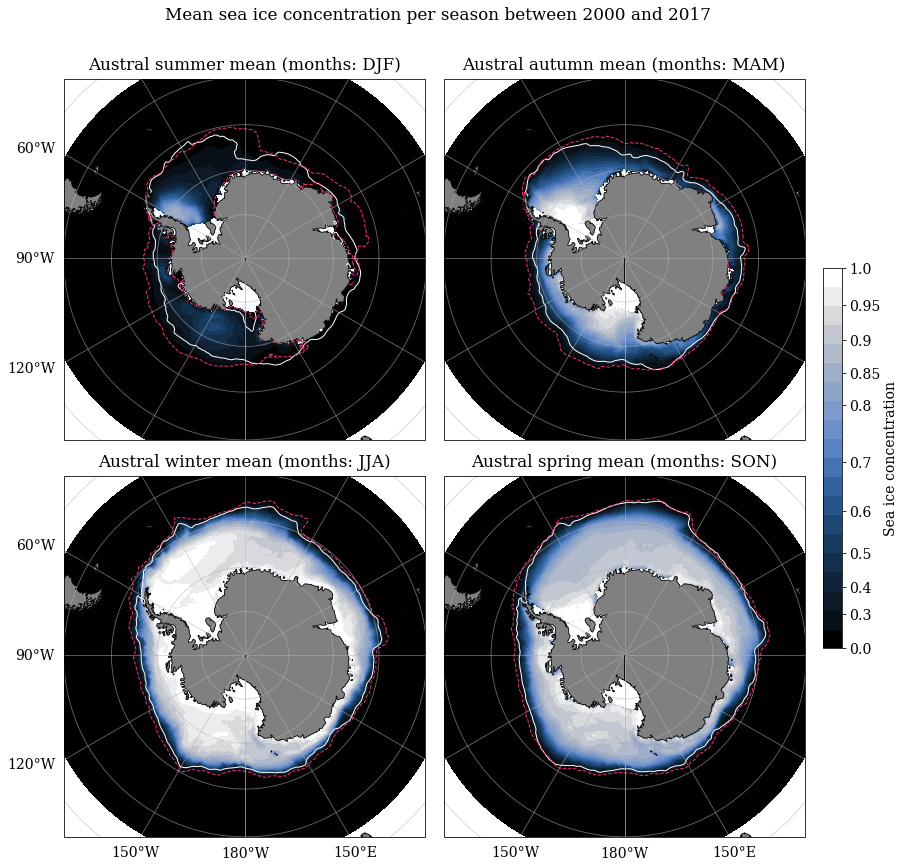

In [57]:
SeasonalSeaIceMap2(SO, CN_obs_SH, palette = 'oslo')

# plt.figure()
# ax = plt.axes(projection = ccrs.SouthPolarStereo())
# # # fig, ax = plt.subplots(subplot_kw={'projection': ccrs.SouthPolarStereo()})
# ax.set_extent([40, 220, -80, -45])
# ax.gridlines(draw_labels=True)
# ax.coastlines(resolution = '50m')
# ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5))
# ax.contourf(x.sel(season='DJF'), transform = ccrs.SouthPolarStereo(), cmap = cm.cm.ice)
# m.plt.axes(projection = ccrs.PlateCarree())

# x = CN_obs_SH.groupby('time.season').mean('time', skipna = True)
# m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
# # xobs, yobs = m(*(x.longitude.data, x.latitude.data))
# fig, axes = plt.subplots(figsize = (16, 14), subplot_kw = dict(projection = ccrs.SouthPolarStereo()))
# x.sel(season = 'DJF').plot.contourf(x = 'xgrid', y = 'ygrid', transform = ccrs.SouthPolarStereo())
# # axes.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5))
# x.sel(season = 'DJF').plot.contour(x = 'xgrid', y = 'ygrid', levels = [0.15], colors = 'white', transform = ccrs.SouthPolarStereo())